## Load and Viz Models

In [2]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

In [4]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
model=torch.load('../models/one_layer_64_nuerons_long.pt')

In [7]:
model

BaarleNet(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

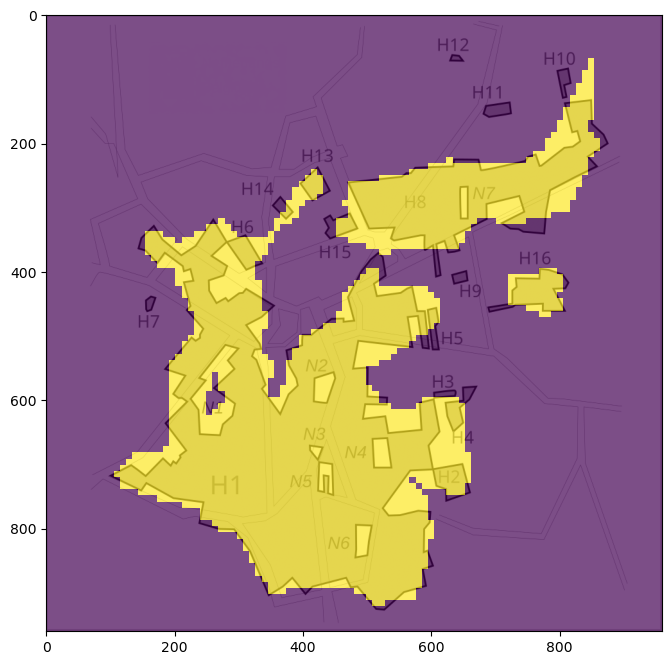

In [8]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [9]:
model=torch.load('../models/one_layer_1024_nuerons_long.pt')

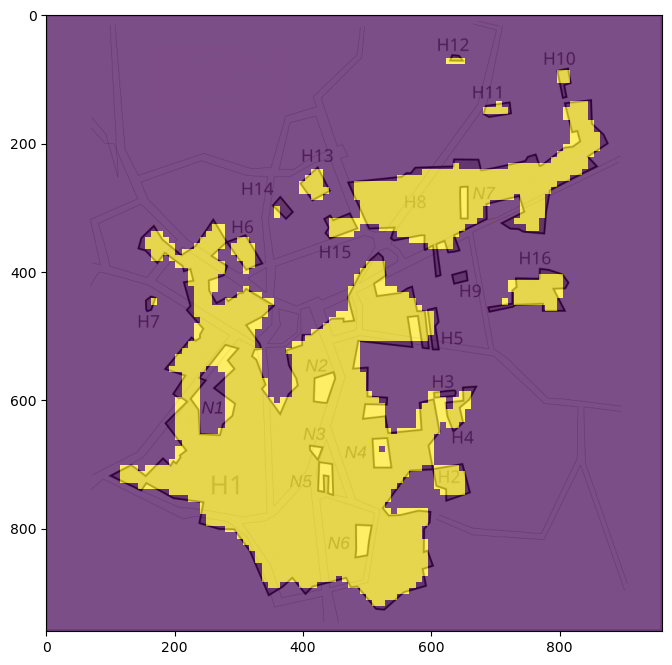

In [10]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

---

In [ ]:
model=torch.load('one_layer_10k_neurons_long.pt')

In [ ]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

In [7]:
model=torch.load('one_layer_100k_neurons_long.pt', weights_only=False)

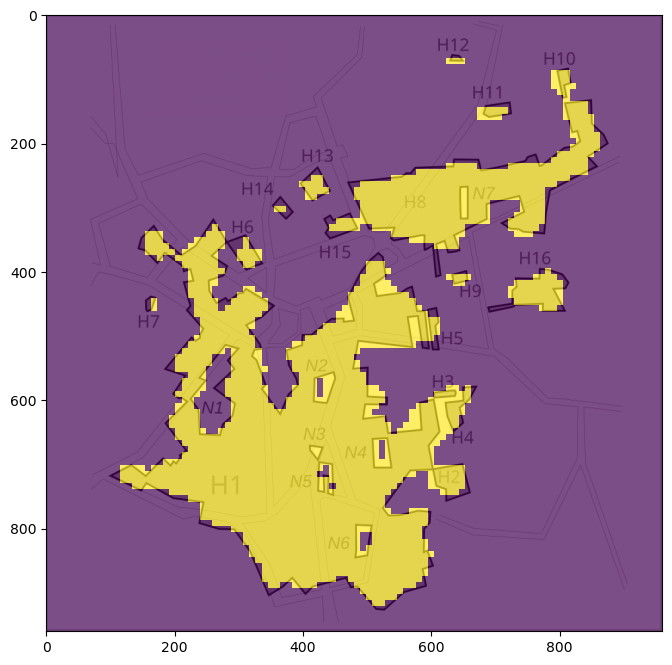

In [9]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float().to('cuda'))
probe_logits=probe_logits.cpu().detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')